In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
import sys
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

#from graph_nets.demos import models

SystemError: Sonnet requires tensorflow_probability (minimum version 0.4.0) to be installed. If using pip, run `pip install tensorflow-probability` or `pip install tensorflow-probability-gpu`

In [2]:

#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '/'.join(parent_path.split('/')[:-1])
#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'testSpecificationRidigBody.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

tr_gen_params = params['training_generation']
te_gen_params = params['testing_generation'] 
ge_gen_params = params['generalization_generation']

tr_rb_params = params['training_rigid_object']
te_rb_params = params['testing_rigid_object']
ge_rb_params = params['generalization_rigid_object']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']




#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
BATCH_SIZE_TR = experiment_params['training_batch_size']
BATCH_SIZE_TE = experiment_params['testing_batch_size']
BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_TIME_STEPS = experiment_params['num_time_steps']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']
STEP_SIZE = experiment_params['step_size']


# Folder description to distinguish between experiment runs
desc = "ntr="+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_btr="+str(BATCH_SIZE_TR)
desc = desc +"_bte="+str(BATCH_SIZE_TE)
desc = desc +"_bge="+str(BATCH_SIZE_GE)
desc = desc +"_ful_l_n="+str(FUL_LAYER_NUMBER)
desc = desc +"_ful_l_s="+str(FUL_LATENT_SIZE)
desc = desc +"_ind_l_n="+str(IND_LAYER_NUMBER)
desc = desc +"_ind_l_s="+str(IND_LATENT_SIZE)
desc = desc +"_date="+str(current_time)

#Set seed
SEED = 6
desc = desc +"seed="+str(SEED)

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.set_random_seed(SEED)

Current_date: 2020-07-23 23:02:02.464442


In [3]:
base = os.path.join(parent_path,'Moving_Rigidbody_Network_sizes','no_gravity_fixed_box_fixed_not_in_error','LayerSize=2')
if(not os.path.exists(base)):
    os.makedirs(base)
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)

    

## Import functions

In [4]:
#Import model
import GNNModels as models
#Import functions for simulating
from Simulation_functions_moving_contact_no_loss_on_fixed import SpringMassSimulator, generate_trajectory, roll_out_physics
#Import functions for creating graph
from Graph_creator_functions import rigid_rectangle_graph_extended
#Import function for experiments
from ExperimentFunctions import create_loss_ops, create_loss_op, make_all_runnable_in_session
#Import visualisation functions
from VisualisationFunctions import plot_groundtruth, plot_groundtruth_and_prediction

# Define the Model

In [5]:
tf.reset_default_graph()
# Create the model.
model = models.EncodeProcessDecode(node_output_size=2,
                                   ind_latent_unit_size=IND_LATENT_SIZE,
                                   ful_latent_unit_size=FUL_LATENT_SIZE,
                                   ind_layer_numbers=IND_LAYER_NUMBER,
                                   ful_layer_numbers=FUL_LAYER_NUMBER)

# Generating Initial Graphs for training and evaluation

In [6]:
#---------Training: dataset parameters---------
POS_NOISE_TR = tr_rb_params['pusher_position_noise_level']
VEL_NOISE_TR = tr_rb_params['pusher_velocity_noise_level']
PUSHER_POS_TR = tr_rb_params['pusher_position']
PUSHER_VEL_TR = tr_rb_params['pusher_velocity']

#---------Training: RigidBody Sizes/Rigidity---------
lena_min_max_tr = (tr_rb_params['side_a_length_min'],tr_rb_params['side_a_length_max'])
lenb_min_max_tr = (tr_rb_params['side_b_length_min'],tr_rb_params['side_b_length_max'])
spring_constant_min_max_tr = (tr_rb_params['spring_constant_min'],tr_rb_params['spring_constant_max'])
damping_ratio_min_max_tr = (tr_rb_params['damping_ratio_min'],tr_rb_params['damping_ratio_max'])

spring_constants_tr = rand.randint(*spring_constant_min_max_tr, size=BATCH_SIZE_TR)
damping_ratios_tr = rand.uniform(*damping_ratio_min_max_tr, size=BATCH_SIZE_TR)

lena_tr = rand.uniform(*lena_min_max_tr, size=BATCH_SIZE_TR)
lenb_tr = rand.uniform(*lenb_min_max_tr, size=BATCH_SIZE_TR)

#---------Training: Pusher Positions---------
pos_noise_min_max_tr = (-POS_NOISE_TR,POS_NOISE_TR)
vel_noise_min_max_tr = (-VEL_NOISE_TR,VEL_NOISE_TR)
pos_noise_tr = rand.uniform(*pos_noise_min_max_tr, size=BATCH_SIZE_TR)
vel_noise_tr = rand.uniform(*vel_noise_min_max_tr, size=BATCH_SIZE_TR)

posa_tr = np.array([PUSHER_POS_TR, PUSHER_POS_TR,-PUSHER_POS_TR,-PUSHER_POS_TR]*int(BATCH_SIZE_TR/4)) + np.array(pos_noise_tr)
posb_tr = np.array([PUSHER_POS_TR,-PUSHER_POS_TR, PUSHER_POS_TR,-PUSHER_POS_TR]*int(BATCH_SIZE_TR/4)) + np.array(pos_noise_tr)
vela_tr = np.array([PUSHER_VEL_TR, PUSHER_VEL_TR,-PUSHER_VEL_TR,-PUSHER_VEL_TR]*int(BATCH_SIZE_TR/4)) + np.array(vel_noise_tr)
velb_tr = np.array([PUSHER_VEL_TR,-PUSHER_VEL_TR, PUSHER_VEL_TR,-PUSHER_VEL_TR]*int(BATCH_SIZE_TR/4)) + np.array(vel_noise_tr)

#---------Training: Generate Graphs---------
params_zipped_tr = zip(spring_constants_tr, damping_ratios_tr, posa_tr, posb_tr, vela_tr, velb_tr)
static_graph_tr = [rigid_rectangle_graph_extended(0.2,0.4,c,True,d,p_a,p_b,v_a,v_b,2) for c,d,p_a,p_b,v_a,v_b in params_zipped_tr]
contact_nodes_tr = [static_graph_tr[i]['receivers'][-2:] for i in range(BATCH_SIZE_TR)]
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)




#---------Testing: dataset parameters---------
POS_NOISE_TE = te_rb_params['pusher_position_noise_level']
VEL_NOISE_TE = te_rb_params['pusher_velocity_noise_level']
PUSHER_POS_TE = te_rb_params['pusher_position']
PUSHER_VEL_TE = te_rb_params['pusher_velocity']

#---------Testing: RigidBody Sizes/Rigidity---------
lena_min_max_te = (te_rb_params['side_a_length_min'],te_rb_params['side_a_length_max'])
lenb_min_max_te = (te_rb_params['side_b_length_min'],te_rb_params['side_b_length_max'])
spring_constant_min_max_te = (te_rb_params['spring_constant_min'],te_rb_params['spring_constant_max'])
damping_ratio_min_max_te = (te_rb_params['damping_ratio_min'],te_rb_params['damping_ratio_max'])

spring_constants_te = rand.randint(*spring_constant_min_max_te, size=BATCH_SIZE_TE)
damping_ratios_te = rand.uniform(*damping_ratio_min_max_te, size=BATCH_SIZE_TE)

lena_te = rand.uniform(*lena_min_max_te, size=BATCH_SIZE_TE)
lenb_te = rand.uniform(*lenb_min_max_te, size=BATCH_SIZE_TE)

#---------Testing: Pusher Positions---------
pos_noise_min_max_te = (-POS_NOISE_TE,POS_NOISE_TE)
vel_noise_min_max_te = (-VEL_NOISE_TE,VEL_NOISE_TE)
pos_noise_te = rand.uniform(*pos_noise_min_max_te, size=BATCH_SIZE_TE)
vel_noise_te = rand.uniform(*vel_noise_min_max_te, size=BATCH_SIZE_TE)

posa_te = np.array([PUSHER_POS_TE, PUSHER_POS_TE,-PUSHER_POS_TE,-PUSHER_POS_TE]*int(BATCH_SIZE_TE/4)) + np.array(pos_noise_te)
posb_te = np.array([PUSHER_POS_TE,-PUSHER_POS_TE, PUSHER_POS_TE,-PUSHER_POS_TE]*int(BATCH_SIZE_TE/4)) + np.array(pos_noise_te)
vela_te = np.array([PUSHER_VEL_TE, PUSHER_VEL_TE,-PUSHER_VEL_TE,-PUSHER_VEL_TE]*int(BATCH_SIZE_TE/4)) + np.array(vel_noise_te)
velb_te = np.array([PUSHER_VEL_TE,-PUSHER_VEL_TE, PUSHER_VEL_TE,-PUSHER_VEL_TE]*int(BATCH_SIZE_TE/4)) + np.array(vel_noise_te)

#---------Testing: Generate Graphs---------
params_zipped_te = zip(spring_constants_te, damping_ratios_te, posa_te, posb_te, vela_te, velb_te)
static_graph_te = [rigid_rectangle_graph_extended(0.2,0.4,c,True,d,p_a,p_b,v_a,v_b,2) for c,d,p_a,p_b,v_a,v_b in params_zipped_te]
contact_nodes_te = [static_graph_te[i]['receivers'][-2:] for i in range(BATCH_SIZE_TE)]
base_graph_te = utils_tf.data_dicts_to_graphs_tuple(static_graph_te)






#---------Generalisation: dataset parameters---------
POS_NOISE_GE = ge_rb_params['pusher_position_noise_level']
VEL_NOISE_GE = ge_rb_params['pusher_velocity_noise_level']
PUSHER_POS_GE = ge_rb_params['pusher_position']
PUSHER_VEL_GE = ge_rb_params['pusher_velocity']

#---------Generalisation: RigidBody Sizes/Rigidity---------
lena_min_max_ge = (ge_rb_params['side_a_length_min'],ge_rb_params['side_a_length_max'])
lenb_min_max_ge = (ge_rb_params['side_b_length_min'],ge_rb_params['side_b_length_max'])
spring_constant_min_max_ge = (ge_rb_params['spring_constant_min'],ge_rb_params['spring_constant_max'])
damping_ratio_min_max_ge = (ge_rb_params['damping_ratio_min'],ge_rb_params['damping_ratio_max'])

spring_constants_ge = rand.randint(*spring_constant_min_max_ge, size=BATCH_SIZE_GE)
damping_ratios_ge = rand.uniform(*damping_ratio_min_max_ge, size=BATCH_SIZE_GE)

lena_ge = rand.uniform(*lena_min_max_ge, size=BATCH_SIZE_GE)
lenb_ge = rand.uniform(*lenb_min_max_ge, size=BATCH_SIZE_GE)

#---------Generalisation: Pusher Positions---------
pos_noise_min_max_ge = (-POS_NOISE_TE,POS_NOISE_GE)
vel_noise_min_max_ge = (-VEL_NOISE_TE,VEL_NOISE_GE)
pos_noise_ge = rand.uniform(*pos_noise_min_max_ge, size=BATCH_SIZE_GE)
vel_noise_ge = rand.uniform(*vel_noise_min_max_ge, size=BATCH_SIZE_GE)

posa_ge = np.array([PUSHER_POS_GE, PUSHER_POS_GE,-PUSHER_POS_GE,-PUSHER_POS_GE]*int(BATCH_SIZE_GE/4)) + np.array(pos_noise_ge)
posb_ge = np.array([PUSHER_POS_GE,-PUSHER_POS_GE, PUSHER_POS_GE,-PUSHER_POS_GE]*int(BATCH_SIZE_GE/4)) + np.array(pos_noise_ge)
vela_ge = np.array([PUSHER_VEL_GE, PUSHER_VEL_GE,-PUSHER_VEL_GE,-PUSHER_VEL_GE]*int(BATCH_SIZE_GE/4)) + np.array(vel_noise_ge)
velb_ge = np.array([PUSHER_VEL_GE,-PUSHER_VEL_GE, PUSHER_VEL_GE,-PUSHER_VEL_GE]*int(BATCH_SIZE_GE/4)) + np.array(vel_noise_ge)

#---------Generalisation: Generate Graphs---------
params_zipped_ge = zip(spring_constants_ge, damping_ratios_ge, posa_ge, posb_ge, vela_te, velb_ge)
static_graph_ge = [rigid_rectangle_graph_extended(0.2,0.4,c,True,d,p_a,p_b,v_a,v_b,2) for c,d,p_a,p_b,v_a,v_b in params_zipped_ge]
contact_nodes_ge = [static_graph_ge[i]['receivers'][-2:] for i in range(BATCH_SIZE_GE)]
base_graph_ge = utils_tf.data_dicts_to_graphs_tuple(static_graph_ge)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=STEP_SIZE)

#---------Begin: Training data: trajectory generation---------
# Generate a training trajectory by adding noise to initial position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    NUM_TIME_STEPS,
    STEP_SIZE,
    node_noise_level=tr_gen_params['node_noise_level'],
    edge_noise_level=tr_gen_params['edge_noise_level'],
    global_noise_level=tr_gen_params['global_noise_level'],
    do_set_rest=tr_gen_params['do_set_rest'],
    do_apply_gravity=tr_gen_params['do_apply_gravity'])
#---------End: Training data: trajectory generation---------


#---------Begin: Test data: trajectory generation---------
# Generate a testing trajectory by adding noise to initial position, spring constants and gravity
initial_conditions_te, true_trajectory_te = generate_trajectory(
    simulator,
    base_graph_te,
    NUM_TIME_STEPS,
    STEP_SIZE,
    node_noise_level=te_gen_params['node_noise_level'],
    edge_noise_level=te_gen_params['edge_noise_level'],
    global_noise_level=te_gen_params['global_noise_level'],
    do_set_rest=te_gen_params['do_set_rest'],
    do_apply_gravity=te_gen_params['do_apply_gravity'])
#---------End: Test data: trajectory generation---------


#---------Begin: Generalisation data: trajectory generation---------
# Generate a testing trajectory by adding noise to initial position, spring constants and gravity
initial_conditions_ge, true_trajectory_ge = generate_trajectory(
    simulator,
    base_graph_ge,
    NUM_TIME_STEPS,
    STEP_SIZE,
    node_noise_level=ge_gen_params['node_noise_level'],
    edge_noise_level=ge_gen_params['edge_noise_level'],
    global_noise_level=ge_gen_params['global_noise_level'],
    do_set_rest=ge_gen_params['do_set_rest'],
    do_apply_gravity=ge_gen_params['do_apply_gravity'])
#---------End: Generalisation data: trajectory generation---------





# Random timestep shared across all 3 datasets
t = tf.random_uniform([], minval=0, maxval=NUM_TIME_STEPS - 1, dtype=tf.int32)

#---------Begin: Training data: dataset set generation---------
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]

output_ops_tr = model(input_graph_tr, NUM_PROCESSING_STEPS_TR)
output_op_tr = output_ops_tr[0].nodes

#----Begin: Fixed nodes to be excluded from the dataset----
n_nodes_in_train_tr = output_op_tr.shape[0]
boolean_l_tr = np.array([True]*n_nodes_in_train_tr)
indices_of_fixed_tr = np.array(list(range(4,n_nodes_in_train_tr,5)))
boolean_l_tr[indices_of_fixed_tr] = False

changed_output_op_tr = tf.boolean_mask(output_op_tr,boolean_l_tr)
changed_target_nodes_tr = tf.boolean_mask(target_nodes_tr,boolean_l_tr)
#----End: Fixed nodes to be excluded from the dataset----

_, true_nodes_rollout_tr = roll_out_physics(
    simulator, initial_conditions_tr, NUM_TIME_STEPS, STEP_SIZE)
_, predicted_nodes_rollout_tr = roll_out_physics(
    lambda x: model(x, NUM_PROCESSING_STEPS_TR), initial_conditions_tr,
    NUM_TIME_STEPS, STEP_SIZE)
#---------End: Training data: dataset set generation---------


#---------Begin: Testing data: dataset set generation---------
input_graph_te = initial_conditions_te.replace(nodes=true_trajectory_te[t])
target_nodes_te = true_trajectory_te[t + 1]

output_ops_te = model(input_graph_te, NUM_PROCESSING_STEPS_TE)
output_op_te = output_ops_te[0].nodes

#----Begin: Fixed nodes to be excluded from the dataset----
n_nodes_in_train_te = output_op_te.shape[0]
boolean_l_te = np.array([True]*n_nodes_in_train_te)
indices_of_fixed_te = np.array(list(range(4,n_nodes_in_train_te,5)))
boolean_l_te[indices_of_fixed_te] = False

changed_output_op_te = tf.boolean_mask(output_op_te,boolean_l_te)
changed_target_nodes_te = tf.boolean_mask(target_nodes_te,boolean_l_te)
#----End: Fixed nodes to be excluded from the dataset----
_, true_nodes_rollout_te = roll_out_physics(
    simulator, initial_conditions_te, NUM_TIME_STEPS, STEP_SIZE)
_, predicted_nodes_rollout_te = roll_out_physics(
    lambda x: model(x, NUM_PROCESSING_STEPS_TE), initial_conditions_te,
    NUM_TIME_STEPS, STEP_SIZE)
#---------End: Testing data: dataset set generation---------


#---------Begin: Generalisation data: dataset set generation---------
input_graph_ge = initial_conditions_ge.replace(nodes=true_trajectory_ge[t])
target_nodes_ge = true_trajectory_ge[t + 1]

output_ops_ge = model(input_graph_ge, NUM_PROCESSING_STEPS_GE)
output_op_ge = output_ops_ge[0].nodes

#----Begin: Fixed nodes to be excluded from the dataset----
n_nodes_in_train_ge = output_op_ge.shape[0]
boolean_l_ge = np.array([True]*n_nodes_in_train_ge)
indices_of_fixed_ge = np.array(list(range(4,n_nodes_in_train_ge,5)))
boolean_l_ge[indices_of_fixed_ge] = False

changed_output_op_ge = tf.boolean_mask(output_op_ge,boolean_l_ge)
changed_target_nodes_ge = tf.boolean_mask(target_nodes_ge,boolean_l_ge)
#----End: Fixed nodes to be excluded from the dataset----

_, true_nodes_rollout_ge = roll_out_physics(
    simulator, initial_conditions_ge, NUM_TIME_STEPS, STEP_SIZE)
_, predicted_nodes_rollout_ge = roll_out_physics(
    lambda x: model(x, NUM_PROCESSING_STEPS_GE), initial_conditions_ge,
    NUM_TIME_STEPS, STEP_SIZE)
#---------End: Generalisation data: dataset set generation---------



#---------Begin: Training: Error function---------
loss_ops_tr = create_loss_op(changed_target_nodes_tr, changed_output_op_tr)
# Training loss across processing steps.
loss_op_step_tr = sum(loss_ops_tr) / NUM_PROCESSING_STEPS_TR
loss_op_tr = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_tr[..., 2:4] -
        true_nodes_rollout_tr[..., 2:4])**2,
        axis=-1))
#---------End: Training: Error function---------

#---------Begin: Test: Error function---------
loss_ops_te = create_loss_op(changed_target_nodes_te,changed_output_op_te)
# Test loss across processing steps.
loss_op_step_te = sum(loss_ops_te) / NUM_PROCESSING_STEPS_TE
loss_op_te = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_te[..., 2:4] -
         true_nodes_rollout_te[..., 2:4])**2,
        axis=-1))
#---------End: Test: Error function---------


#---------Begin: Generalisation: Error function---------
loss_ops_ge = create_loss_op(changed_target_nodes_ge,changed_output_op_ge)
# Generalisation loss across processing steps.
loss_op_step_ge = sum(loss_ops_ge) / NUM_PROCESSING_STEPS_GE
loss_op_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_ge[..., 2:4] -
         true_nodes_rollout_ge[..., 2:4])**2,
        axis=-1))
#---------End: Generalisation: Error function---------


# Optimizer.
LEARNING_RATE = model_params['learning_rate']
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
step_op = optimizer.minimize(loss_op_step_tr)

input_graph_tr = make_all_runnable_in_session(input_graph_tr)
initial_conditions_te = make_all_runnable_in_session(initial_conditions_te)
initial_conditions_ge = make_all_runnable_in_session(initial_conditions_ge)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



### Reset Tensorflow session, but keep the same computational graph.

In [8]:
#@title Reset session  { form-width: "30%" }
saver = tf.train.Saver()
try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#var = [v for v in tf.trainable_variables() if v.name == 'MLPGraphNetwork/graph_network/edge_block/mlp/linear_0/w:0']
#pre_train_np = sess.run(var)


last_iteration = 0
logged_iterations = []
logged_timesteps = []
losses_tr = []
losses_step_tr = []
losses_te = []
losses_step_te = []
losses_ge = []
losses_step_ge = []

### Train Network

In [9]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_iteration = 250

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lte (test 1-step loss for test rigidbodies), "
      "Lge (generalization 1-step loss for extrapolation rigidbodies)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    train_values = sess.run({
        "step_loss_tr": loss_op_step_tr,
        "step_loss_te":loss_op_step_te,
        "step_loss_ge":loss_op_step_ge,
        "step": step_op,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr,
        "time_step":t
    })
    if last_iteration % log_every_iteration == 0:
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        test_values = sess.run({
            "loss_tr": loss_op_tr,
            "loss_te": loss_op_te,
            "true_rollout_te": true_nodes_rollout_te,
            "predicted_rollout_te": predicted_nodes_rollout_te,
            "loss_ge": loss_op_ge,
            "true_rollout_ge": true_nodes_rollout_ge,
            "predicted_rollout_ge": predicted_nodes_rollout_ge
        })
        elapsed = time.time() - start_time
        losses_tr.append(test_values["loss_tr"])
        losses_step_tr.append(train_values["step_loss_tr"])
        losses_te.append(test_values["loss_te"])
        losses_step_te.append(train_values["step_loss_te"])
        losses_ge.append(test_values["loss_ge"])
        losses_step_ge.append(train_values["step_loss_ge"])
        logged_iterations.append(iteration)
        logged_timesteps.append(train_values["time_step"])
        print("# {:05d}, T {:.1f}, Ltr {:.6f}, Lte {:.6f}, Lge {:.6f}, TimeStep {:03d}".format(
            iteration, elapsed, train_values["step_loss_tr"], train_values["step_loss_te"],
            train_values["step_loss_ge"],train_values["time_step"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lte (test 1-step loss for test rigidbodies), Lge (generalization 1-step loss for extrapolation rigidbodies)
# 00000, T 2.2, Ltr 1.558083, Lte 1.549432, Lge 1.576538, TimeStep 025
# 00250, T 14.6, Ltr 0.004769, Lte 0.004523, Lge 0.004711, TimeStep 017
# 00500, T 27.0, Ltr 0.001883, Lte 0.001910, Lge 0.001750, TimeStep 018
# 00750, T 39.4, Ltr 0.000866, Lte 0.000977, Lge 0.000858, TimeStep 037
# 01000, T 51.7, Ltr 0.010629, Lte 0.010247, Lge 0.010486, TimeStep 003
# 01250, T 64.1, Ltr 0.001784, Lte 0.001786, Lge 0.001619, TimeStep 007
# 01500, T 76.5, Ltr 0.000348, Lte 0.000448, Lge 0.000391, TimeStep 037
# 01750, T 88.9, Ltr 0.000419, Lte 0.000515, Lge 0.000427, TimeStep 032
# 02000, T 101.2, Ltr 0.000256, Lte 0.000292, Lge 0.000295, TimeStep 038
# 02250, T 113.6, Ltr 0.002529, Lte 0.002516, Lge 0.002524, TimeStep 000
# 02500, T 125.9, Ltr 0.000388, Lte 0.000487, Lge 0.000401, TimeStep 034
# 02750, T 138.3, Ltr 0.000

# 27500, T 1364.4, Ltr 0.000369, Lte 0.000369, Lge 0.000364, TimeStep 020
# 27750, T 1376.8, Ltr 0.000263, Lte 0.000260, Lge 0.000278, TimeStep 026
# 28000, T 1389.1, Ltr 0.000074, Lte 0.000080, Lge 0.000102, TimeStep 039
# 28250, T 1401.6, Ltr 0.000164, Lte 0.000150, Lge 0.000180, TimeStep 023
# 28500, T 1414.0, Ltr 0.000079, Lte 0.000081, Lge 0.000122, TimeStep 048
# 28750, T 1426.4, Ltr 0.000357, Lte 0.000354, Lge 0.000413, TimeStep 045
# 29000, T 1438.8, Ltr 0.000376, Lte 0.000333, Lge 0.000384, TimeStep 014
# 29250, T 1451.2, Ltr 0.002137, Lte 0.002066, Lge 0.002018, TimeStep 007
# 29500, T 1463.5, Ltr 0.000272, Lte 0.000255, Lge 0.000264, TimeStep 019
# 29750, T 1475.8, Ltr 0.000130, Lte 0.000112, Lge 0.000151, TimeStep 034
# 30000, T 1488.2, Ltr 0.000303, Lte 0.000299, Lge 0.000283, TimeStep 018
# 30250, T 1500.6, Ltr 0.001091, Lte 0.000983, Lge 0.001013, TimeStep 012
# 30500, T 1512.9, Ltr 0.000558, Lte 0.000546, Lge 0.000551, TimeStep 013
# 30750, T 1525.3, Ltr 0.000338, Lte 0

# 55250, T 2738.7, Ltr 0.000666, Lte 0.000703, Lge 0.000602, TimeStep 007
# 55500, T 2751.1, Ltr 0.000065, Lte 0.000060, Lge 0.000085, TimeStep 033
# 55750, T 2763.5, Ltr 0.000056, Lte 0.000059, Lge 0.000097, TimeStep 045
# 56000, T 2775.9, Ltr 0.000795, Lte 0.000856, Lge 0.000769, TimeStep 006
# 56250, T 2788.3, Ltr 0.000657, Lte 0.000579, Lge 0.000576, TimeStep 012
# 56500, T 2800.7, Ltr 0.000089, Lte 0.000097, Lge 0.000117, TimeStep 037
# 56750, T 2813.0, Ltr 0.000479, Lte 0.000478, Lge 0.000404, TimeStep 017
# 57000, T 2825.4, Ltr 0.000345, Lte 0.000300, Lge 0.000321, TimeStep 021
# 57250, T 2837.8, Ltr 0.000127, Lte 0.000131, Lge 0.000140, TimeStep 033
# 57500, T 2850.3, Ltr 0.000065, Lte 0.000062, Lge 0.000083, TimeStep 035
# 57750, T 2862.6, Ltr 0.000052, Lte 0.000058, Lge 0.000087, TimeStep 043
# 58000, T 2875.0, Ltr 0.000070, Lte 0.000067, Lge 0.000090, TimeStep 039
# 58250, T 2887.5, Ltr 0.000094, Lte 0.000088, Lge 0.000122, TimeStep 031
# 58500, T 2899.8, Ltr 0.000066, Lte 0

# 83000, T 4114.9, Ltr 0.000462, Lte 0.000393, Lge 0.000450, TimeStep 021
# 83250, T 4127.3, Ltr 0.000039, Lte 0.000040, Lge 0.000071, TimeStep 048
# 83500, T 4139.6, Ltr 0.000074, Lte 0.000075, Lge 0.000104, TimeStep 040
# 83750, T 4152.0, Ltr 0.000352, Lte 0.000293, Lge 0.000321, TimeStep 021
# 84000, T 4164.4, Ltr 0.000036, Lte 0.000040, Lge 0.000067, TimeStep 046
# 84250, T 4176.8, Ltr 0.000050, Lte 0.000041, Lge 0.000067, TimeStep 034
# 84500, T 4189.2, Ltr 0.000347, Lte 0.000316, Lge 0.000354, TimeStep 021
# 84750, T 4201.5, Ltr 0.000068, Lte 0.000067, Lge 0.000091, TimeStep 032
# 85000, T 4213.9, Ltr 0.000050, Lte 0.000052, Lge 0.000071, TimeStep 037
# 85250, T 4226.4, Ltr 0.000677, Lte 0.000713, Lge 0.000644, TimeStep 005
# 85500, T 4238.7, Ltr 0.000087, Lte 0.000088, Lge 0.000131, TimeStep 048
# 85750, T 4251.1, Ltr 0.000593, Lte 0.000572, Lge 0.000545, TimeStep 007
# 86000, T 4263.5, Ltr 0.000678, Lte 0.000726, Lge 0.000735, TimeStep 004
# 86250, T 4275.8, Ltr 0.000127, Lte 0

## Save Model

In [10]:
if os.path.exists(os.path.join(path_saves, "model.ckpt")):
    print("The file: "+ "model.ckpt" + "already exists. Delete it before saving a new trajectory!")
else:
    save_path = saver.save(sess, os.path.join(path_saves)+"/model.ckpt")
    print("Model saved in path: %s" % save_path)
        
        



Model saved in path: /home/bence/git_workspace/Dyadic_Collaboration/Graph_Networks/Phases/Phase2/Moving_Rigidbody_Network_sizes/no_gravity_fixed_box_fixed_not_in_error/LayerSize=2/ntr=100000_btr=256_bte=100_bge=100_ful_l_n=2_ful_l_s=16_ind_l_n=2_ind_l_s=16_date=072320seed=5/Saves/model.ckpt


## Load Model (Optional)

In [11]:
#saver.restore(sess,os.path.join(path_saves)+"/model.ckpt")

#var = [v for v in tf.trainable_variables() if v.name == 'MLPGraphNetwork/graph_network/edge_block/mlp/linear_0/w:0']
#post_restore_np = sess.run(var)
#print(np.array(post_restore_np))

## Save Trajectories

In [12]:
#Describe the experiment


def get_node_trajectories(rollout_array, batch_size):
    return np.split(rollout_array[..., :4], batch_size, axis=1)

#Store the data
true_rollouts_te = get_node_trajectories(test_values["true_rollout_te"],BATCH_SIZE_TE)
true_trajectory_te_np = np.array(true_rollouts_te)

predicted_rollouts_te = get_node_trajectories(test_values["predicted_rollout_te"],BATCH_SIZE_TE)
predicted_trajectory_te_np=np.array(predicted_rollouts_te)

true_rollouts_ge = get_node_trajectories(test_values["true_rollout_ge"],BATCH_SIZE_GE)
true_trajectory_ge_np = np.array(true_rollouts_ge)

predicted_rollouts_ge = get_node_trajectories(test_values["predicted_rollout_ge"],BATCH_SIZE_GE)
predicted_trajectory_ge_np=np.array(predicted_rollouts_ge)


l_names = ["true_trajectory_te.npy",
           "predicted_trajectory_te.npy",
           "true_trajectory_ge.npy",
           "predicted_trajectory_ge.npy"]

l_data = [true_trajectory_te_np,
          predicted_trajectory_te_np,
          true_trajectory_ge_np,
          predicted_trajectory_ge_np]


for fname, fdata in zip(l_names,l_data):
    if os.path.exists(os.path.join(path_saves, fname)):
        print("The file: "+ fname + "already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.mkdir(os.path.join(path_saves)) 
        np.save(os.path.join(path_saves, fname), fdata)

In [13]:
# Choose a simulated system
index_of_simulated_system = -1

spring_const_ge = spring_constants_ge[index_of_simulated_system]
damping_ratio_ge = damping_ratios_ge[index_of_simulated_system]

spring_const_te = spring_constants_te[index_of_simulated_system]
damping_ratio_te = damping_ratios_te[index_of_simulated_system]

contact_nodes_te = contact_nodes_te[index_of_simulated_system]
true_trajectory_te_np = true_trajectory_te_np[index_of_simulated_system]
predicted_trajectory_te_np = predicted_trajectory_te_np[index_of_simulated_system]
contact_nodes_ge = contact_nodes_ge[index_of_simulated_system]
true_trajectory_ge_np = true_trajectory_ge_np[index_of_simulated_system]
predicted_trajectory_ge_np = predicted_trajectory_ge_np[index_of_simulated_system]

## Plot and Save Step Error Convergence  plot

<IPython.core.display.Javascript object>


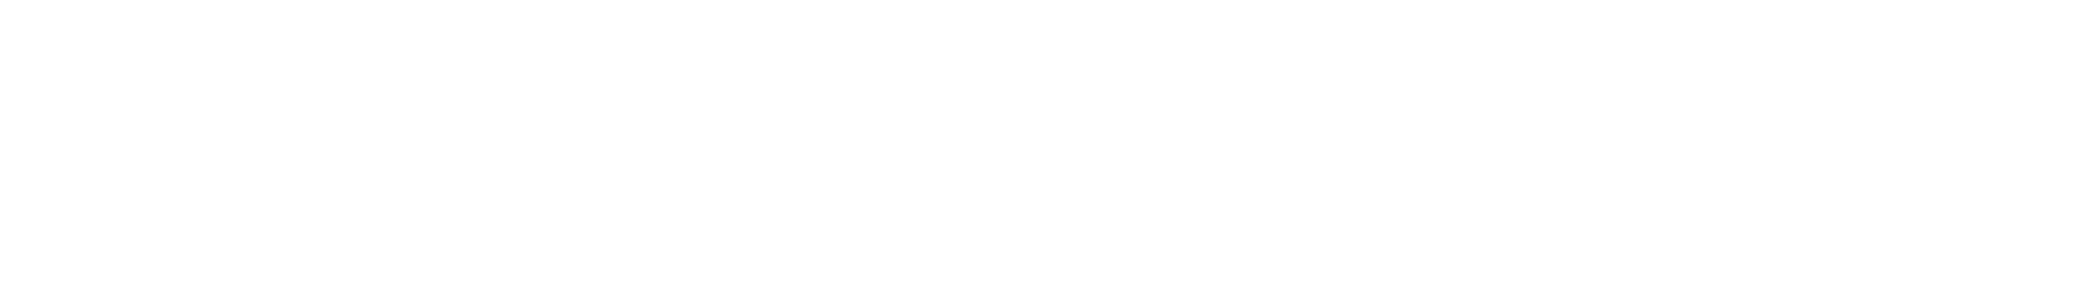

In [14]:
fig = plt.figure(1, figsize=(21, 3))
fig.clf()
x = np.array(logged_iterations)



if os.path.exists(os.path.join(path_saves, "logged_iterations")):
    print("The file: "+ "logged_iterations" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "logged_iterations"), x)
    
if os.path.exists(os.path.join(path_saves, "logged_time_steps")):
    print("The file: "+ "logged_time_steps" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "logged_time_steps"), logged_timesteps)
        
# Next-step Loss tr
y = losses_step_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Step loss: Training")
if os.path.exists(os.path.join(path_saves, "losses_step_tr")):
    print("The file: "+ "losses_step_tr" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_step_tr"), losses_step_tr)

        
# Next-step Loss te
y = losses_step_te
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Step loss: test")

if os.path.exists(os.path.join(path_saves, "losses_step_te")):
    print("The file: "+ "losses_step_te" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_step_te"), losses_step_te)



# Next-step Loss ge
y = losses_step_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Step loss: generalisation")

if os.path.exists(os.path.join(path_saves, "losses_step_ge")):
    print("The file: "+ "losses_step_ge" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_step_ge"), losses_step_ge)


#Save figure
if os.path.exists(os.path.join(path_plots,"StepConvergencePlot.png")):
    print("The file: "+ "StepConvergencePlot.png" + "already exists. Delete it before saving a new plot!")
else:
    if not os.path.exists(os.path.join(path_plots)):
        os.mkdir(os.path.join(path_plots))
                  
    fig.savefig(os.path.join(path_plots,"StepConvergencePlot.png"))

In [15]:
fig = plt.figure(1, figsize=(21, 3))
fig.clf()
x = np.array(logged_iterations)
        
# Next-step Loss tr
y = np.log(losses_step_tr)
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Step loss, LogScale: training")

        
# Next-step Loss te
y = np.log(losses_step_te)
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Step loss, LogScale: test")



# Next-step Loss ge
y = np.log(losses_step_ge)
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Step loss, LogScale: generalisation")


#Save figure
if os.path.exists(os.path.join(path_plots,"StepConvergencePlotLogScale.png")):
    print("The file: "+ "StepConvergencePlotLogScale.png" + "already exists. Delete it before saving a new plot!")
else:
    if not os.path.exists(os.path.join(path_plots)):
        os.mkdir(os.path.join(path_plots))
                  
    fig.savefig(os.path.join(path_plots,"StepConvergencePlotLogScale.png"))

## Plot and Save Rollout Error  Convergence  plot

In [16]:
fig = plt.figure(1, figsize=(21, 3))
fig.clf()
x = np.array(logged_iterations)
        
# Rollout loss tr
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: training")

if os.path.exists(os.path.join(path_saves, "losses_tr")):
    print("The file: "+ "losses_tr" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_tr"), losses_tr)


        
# Rollout loss te
y = losses_te
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: test")


if os.path.exists(os.path.join(path_saves, "losses_te")):
    print("The file: "+ "losses_te" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_te"), losses_te)


# Rollout loss ge
y = losses_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: generalisation")

if os.path.exists(os.path.join(path_saves, "losses_ge")):
    print("The file: "+ "losses_ge" + "already exists. Delete it before saving a new trajectory!")
else:
    if not os.path.exists(os.path.join(path_saves)):
        os.makedirs(os.path.join(path_saves)) 
    np.save(os.path.join(path_saves, "losses_ge"), losses_ge)


#Save figure
if os.path.exists(os.path.join(path_plots,"RolloutConvergencePlot.png")):
    print("The file: "+ "RolloutConvergencePlot.png" + "already exists. Delete it before saving a new plot!")
else:
    if not os.path.exists(os.path.join(path_plots)):
        os.mkdir(os.path.join(path_plots))
                  
    fig.savefig(os.path.join(path_plots,"RolloutConvergencePlot.png"))

In [17]:
fig = plt.figure(1, figsize=(21, 3))
fig.clf()
x = np.array(logged_iterations)

# Rollout loss tr
y = np.log(losses_tr)
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Rollout loss, LogScale: training")

        
# Rollout loss te
y = np.log(losses_te)
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss, LogScale: test")


# Rollout loss ge
y = np.log(losses_ge)
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss, LogScale: generalisation")



#Save figure
if os.path.exists(os.path.join(path_plots,"RolloutConvergencePlotLogScale.png")):
    print("The file: "+ "RolloutConvergencePlotLogScale.png" + "already exists. Delete it before saving a new plot!")
else:
    if not os.path.exists(os.path.join(path_plots)):
        os.mkdir(os.path.join(path_plots))
                  
    fig.savefig(os.path.join(path_plots,"RolloutConvergencePlotLogScale.png"))

## Plot and Save Trajectories Error plot

### Plot generated groundtruth for test system

<IPython.core.display.Javascript object>


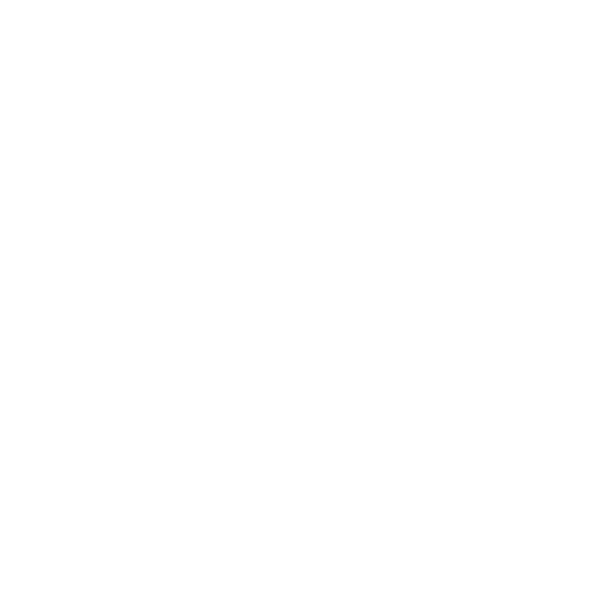

In [18]:
plt.close('all')
fig,ax,anim = plot_groundtruth(true_trajectory_te_np, spring_const_te, damping_ratio_te, contact_nodes_te, path_animations, "ground_trajectory_te_masses")
plt.show()

### Plot generated groundtruth for generalisation system

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


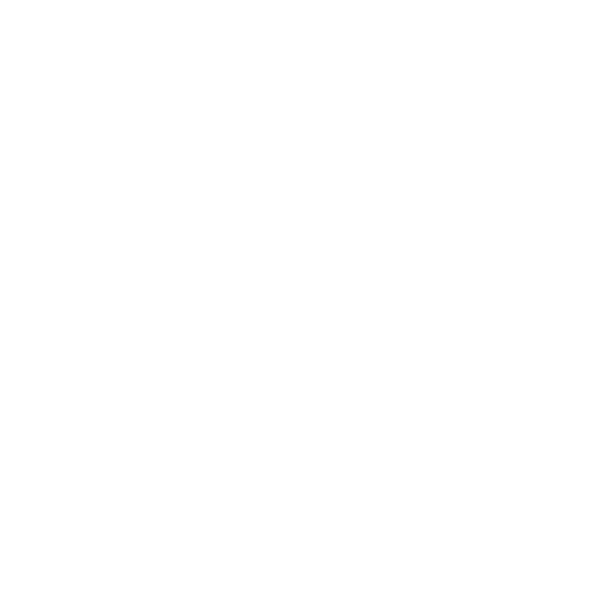

In [19]:
plt.close('all')
fig,ax,anim = plot_groundtruth(true_trajectory_ge_np, spring_const_ge, damping_ratio_ge, contact_nodes_ge, path_animations, "ground_trajectory_ge_masses")
plt.show()

### Plot rollout for test system

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


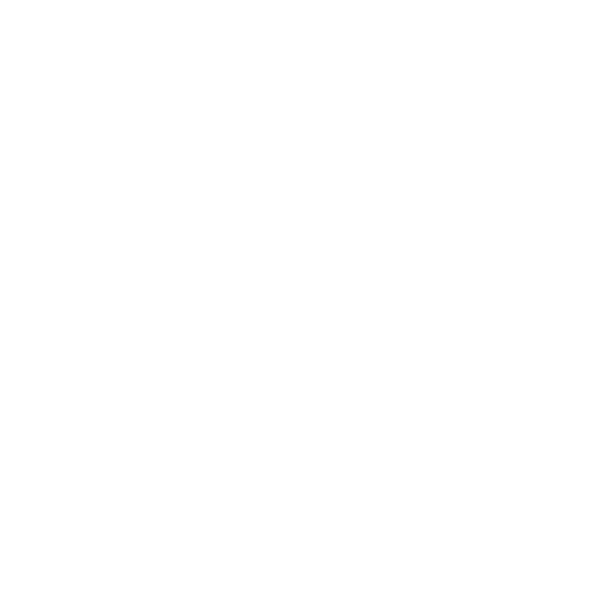

In [20]:
plt.close('all')
fig,ax,anim = plot_groundtruth_and_prediction(true_trajectory_te_np, predicted_trajectory_te_np, spring_const_te, damping_ratio_te, contact_nodes_te, path_animations, "pred_and_ground_trajectory_te_masses")
plt.show()

### Plot rollout for generalisation system

Traceback (most recent call last):
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/bence/miniconda3/envs/tensorEnv/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


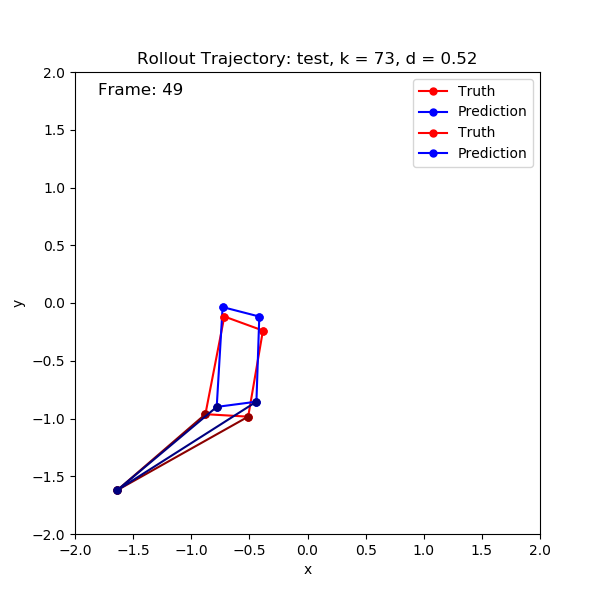

In [21]:
plt.close('all')
fig,ax,anim = plot_groundtruth_and_prediction(true_trajectory_ge_np, predicted_trajectory_ge_np, spring_const_ge, damping_ratio_ge, contact_nodes_ge, path_animations, "pred_and_ground_trajectory_ge_masses")
plt.show()